# Productivity Cost Sensitivity Analysis

This notebook runs the glaucoma model analysis **three times** with different VI productivity costs:

1. **Low cost scenario**: VI productivity cost = €0.0001
2. **Base case scenario**: VI productivity cost = base case value
3. **Doubled cost scenario**: VI productivity cost = 2 × base case value

The analysis compares AI-enhanced vs traditional glaucoma screening across all three scenarios.

## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

from glaucoma_model.utils import (
    save_scenario_results
)
from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Imports complete")

Parameter class defined!
Enhanced GlaucomaParameters class defined with state-specific screening accuracy, mortality odds ratios, and false positive disutility!
Enhanced models with age-dependent mortality from life tables defined!
✓ Imports complete


## Configuration

In [3]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Create a fresh model to get the base VI productivity cost
temp_model = AIGlaucomaModel()
base_vi_cost = temp_model.params.costs['productivity_vi'].mean
print(f"Base case VI productivity cost: €{base_vi_cost:,.2f}")

# Define THREE scenarios
scenarios = {
    'Low': 0.0001,
    'Base': base_vi_cost,
    'Doubled': base_vi_cost * 2
}

print(f"\nScenario 1 (Low): VI productivity cost = €{scenarios['Low']:,.4f}")
print(f"Scenario 2 (Base): VI productivity cost = €{scenarios['Base']:,.2f}")
print(f"Scenario 3 (Doubled): VI productivity cost = €{scenarios['Doubled']:,.2f}")

Base case VI productivity cost: €7,630.00

Scenario 1 (Low): VI productivity cost = €0.0001
Scenario 2 (Base): VI productivity cost = €7,630.00
Scenario 3 (Doubled): VI productivity cost = €15,260.00


## Define Helper Function

This function runs the complete analysis for a single VI productivity cost value.

In [4]:
def run_single_scenario(vi_productivity_cost, scenario_name):
    """
    Run the complete analysis for a single VI productivity cost value
    
    Parameters:
    -----------
    vi_productivity_cost : float
        The productivity cost for VI state
    scenario_name : str
        Name for this scenario
    
    Returns:
    --------
    dict : Results including summary table and comprehensive results
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"VI Productivity Cost: €{vi_productivity_cost:,.2f}")
    print(f"{'='*80}\n")
    
    # Initialize models
    model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
    model_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
    model_non_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    # =========================================================================
    # UPDATE PRODUCTIVITY COSTS - THIS IS THE KEY STEP
    # =========================================================================
    model_ai.params.costs['productivity_vi'].mean = vi_productivity_cost
    model_non_ai.params.costs['productivity_vi'].mean = vi_productivity_cost
    

    
    # Initial distribution (fixed proportions: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead)
    initial_dist = [38, 9, 7, 0, 0]
    initial_dist = np.array(initial_dist) / np.sum(initial_dist)
    
    # Run AI PSA
    print(f"Running AI Model PSA ({N_ITERATIONS} iterations)...")
    ai_psa_results = model_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Run Non-AI PSA
    print(f"Running Non-AI Model PSA ({N_ITERATIONS} iterations)...")
    non_ai_psa_results = model_non_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Adjust for sensitivity and specificity
    print("Adjusting for sensitivity and specificity...")
    ai_traces = ai_psa_results['trace_tensor']
    non_ai_traces = non_ai_psa_results['trace_tensor']
    variable_names = ai_psa_results['trace_variable_names']
    
    ai_eff0_psa_traces = copy.deepcopy(ai_traces)
    ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
    
    sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
    
    # Adjust costs
    for var_name in ['Total_Cost', 'Total_Cost_Disc']:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    # Adjust QALYs
    qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
    for var_name in qaly_vars:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces
    
    # Add screening costs
    idx1 = variable_names.index('Total_Cost')
    idx2 = variable_names.index('Total_Cost_Disc')
    
    prevalence = model_ai.params.screening_params['prevalence_general'].mean

    # AI screening costs
    ai_screening_per_case = (1/prevalence) * model_ai.params.costs['ai_screening'].mean
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += ai_screening_per_case
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += ai_screening_per_case
    
    # False positive costs
    specificity = model_ai.params.screening_accuracy['specificity'].mean
    human_screening_cost = model_ai.params.costs['human_screening'].mean
    false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity)
    
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += false_positives_per_case * human_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += false_positives_per_case * human_screening_cost
    
    # Run comprehensive analysis
    print("Running comprehensive cost-effectiveness analysis...")
    comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10, 15, 20, 30],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
    )
    
    summary_table = create_summary_table(comprehensive_results)
    
    return {
        'scenario_name': scenario_name,
        'vi_productivity_cost': vi_productivity_cost,
        'comprehensive_results': comprehensive_results,
        'summary_table': summary_table,
        'ai_psa_results': ai_psa_results,
        'non_ai_psa_results': non_ai_psa_results,
        'ai_eff0_psa_results': ai_eff0_psa_results
    }

print("✓ Helper function defined")

✓ Helper function defined


## Scenario 1: Low Productivity Costs

Running analysis with VI productivity cost = €0.0001

In [5]:
results_low = run_single_scenario(
    vi_productivity_cost=scenarios['Low'],
    scenario_name="Low Productivity Cost"
)


SCENARIO: Low Productivity Cost
VI Productivity Cost: €0.00

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/500

### Summary Table - Low Cost Scenario

In [6]:
print("\n=== LOW COST SCENARIO - SUMMARY TABLE ===")
print(results_low['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_low['summary_table'])


=== LOW COST SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI    ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                €1,479       [€-675, €3,824]                 0.069       [-0.211, 0.331] €21,462    €5,213        €994 [€-132,255, €141,691]       57.6%       71.7%        77.3%
    10 years                €1,065     [€-3,494, €5,667]                 0.220       [-0.375, 0.788]  €4,840    €2,044        €400  [€-98,370, €103,207]       75.7%       83.4%        85.5%
    15 years                 €-230     [€-7,458, €6,819]                 0.418       [-0.569, 1.369]   €-551      €138     €-1,355   [€-73,086, €78,409]       83.6%       87.4%        88.9%
    20 years               €-1,655    [€-11,386, €7,549]                 0.633       [-0.713, 1.931] €-2,615   €-1,519     €-2,249   [€-62,878, €64,056]       87.6%       90.2%        91.1%
    30 

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,"€1,479","[€-675, €3,824]",0.069,"[-0.211, 0.331]","€21,462","€5,213",€994,"[€-132,255, €141,691]",57.6%,71.7%,77.3%
1,10 years,"€1,065","[€-3,494, €5,667]",0.220,"[-0.375, 0.788]","€4,840","€2,044",€400,"[€-98,370, €103,207]",75.7%,83.4%,85.5%
2,15 years,€-230,"[€-7,458, €6,819]",0.418,"[-0.569, 1.369]",€-551,€138,"€-1,355","[€-73,086, €78,409]",83.6%,87.4%,88.9%
3,20 years,"€-1,655","[€-11,386, €7,549]",0.633,"[-0.713, 1.931]","€-2,615","€-1,519","€-2,249","[€-62,878, €64,056]",87.6%,90.2%,91.1%
4,30 years,"€-2,764","[€-14,337, €8,207]",0.940,"[-0.785, 2.615]","€-2,941","€-2,162","€-2,454","[€-58,028, €50,229]",91.2%,92.7%,93.3%


### Key Results - Low Cost Scenario

In [7]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Low Cost) ===")
    results = results_low['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Low Cost) ===
ICER: €21,462  ICER (95% CI): €5,213 [-132,255, 141,691]
Incremental Cost: €1,479
Incremental QALY: 0.069
Probability cost-effective at €20k/QALY: 57.6%
Probability cost-effective at €50k/QALY: 71.7%
Probability cost-effective at €100k/QALY: 77.3%

=== 10-YEAR RESULTS (Low Cost) ===
ICER: €4,840  ICER (95% CI): €2,044 [-98,370, 103,207]
Incremental Cost: €1,065
Incremental QALY: 0.220
Probability cost-effective at €20k/QALY: 75.7%
Probability cost-effective at €50k/QALY: 83.4%
Probability cost-effective at €100k/QALY: 85.5%

=== 30-YEAR RESULTS (Low Cost) ===
ICER: €-2,941  ICER (95% CI): €-2,162 [-58,028, 50,229]
Incremental Cost: €-2,764
Incremental QALY: 0.940
Probability cost-effective at €20k/QALY: 91.2%
Probability cost-effective at €50k/QALY: 92.7%
Probability cost-effective at €100k/QALY: 93.3%


### Save Low Cost Results

In [8]:
results_low['summary_table'].to_csv('../data/productivity_low_summary.csv', index=False)
print("✓ Low cost scenario results saved to ../data/productivity_low_summary.csv")

✓ Low cost scenario results saved to ../data/productivity_low_summary.csv


## Scenario 2: Base Case Productivity Costs

Running analysis with VI productivity cost = base case value

In [9]:
results_base = run_single_scenario(
    vi_productivity_cost=scenarios['Base'],
    scenario_name="Base Case Productivity Cost"
)


SCENARIO: Base Case Productivity Cost
VI Productivity Cost: €7,630.00

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteratio

### Summary Table - Base Case Scenario

In [10]:
print("\n=== BASE CASE SCENARIO - SUMMARY TABLE ===")
print(results_base['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_base['summary_table'])


=== BASE CASE SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]       95.0%       95.8%        96.0%
 

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


### Key Results - Base Case Scenario

In [11]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Base Case) ===")
    results = results_base['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Base Case) ===
ICER: €11,637  ICER (95% CI): €2,949 [-149,461, 133,426]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.3%

=== 10-YEAR RESULTS (Base Case) ===
ICER: €-5,916  ICER (95% CI): €-2,122 [-127,559, 123,218]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (Base Case) ===
ICER: €-12,237  ICER (95% CI): €-10,457 [-105,881, 81,338]
Incremental Cost: €-11,683
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save Base Case Results

In [12]:
results_base['summary_table'].to_csv('../data/productivity_base_summary.csv', index=False)
print("✓ Base case scenario results saved to ../data/productivity_base_summary.csv")

✓ Base case scenario results saved to ../data/productivity_base_summary.csv


## Scenario 3: Doubled Productivity Costs

Running analysis with VI productivity cost = 2 × base case

In [13]:
results_doubled = run_single_scenario(
    vi_productivity_cost=scenarios['Doubled'],
    scenario_name="Doubled Productivity Cost"
)


SCENARIO: Doubled Productivity Cost
VI Productivity Cost: €15,260.00

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration

### Summary Table - Doubled Cost Scenario

In [14]:
print("\n=== DOUBLED COST SCENARIO - SUMMARY TABLE ===")
print(results_doubled['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_doubled['summary_table'])


=== DOUBLED COST SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €169     [€-3,090, €3,378]                 0.070       [-0.194, 0.330]   €2,409     €-120       €-543 [€-149,273, €133,876]       70.0%       79.6%        83.0%
    10 years               €-3,667    [€-12,068, €4,173]                 0.222       [-0.357, 0.797] €-16,482   €-8,655     €-7,126 [€-164,720, €148,663]       89.2%       91.7%        92.5%
    15 years               €-9,800    [€-24,803, €3,784]                 0.425       [-0.524, 1.356] €-23,083  €-11,708    €-12,744 [€-156,604, €168,280]       95.9%       96.8%        97.0%
    20 years              €-15,854    [€-36,824, €2,965]                 0.645       [-0.674, 1.914] €-24,579  €-16,196    €-15,898 [€-166,762, €152,993]       98.1%       98.3%        98.3

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€169,"[€-3,090, €3,378]",0.070,"[-0.194, 0.330]","€2,409",€-120,€-543,"[€-149,273, €133,876]",70.0%,79.6%,83.0%
1,10 years,"€-3,667","[€-12,068, €4,173]",0.222,"[-0.357, 0.797]","€-16,482","€-8,655","€-7,126","[€-164,720, €148,663]",89.2%,91.7%,92.5%
2,15 years,"€-9,800","[€-24,803, €3,784]",0.425,"[-0.524, 1.356]","€-23,083","€-11,708","€-12,744","[€-156,604, €168,280]",95.9%,96.8%,97.0%
3,20 years,"€-15,854","[€-36,824, €2,965]",0.645,"[-0.674, 1.914]","€-24,579","€-16,196","€-15,898","[€-166,762, €152,993]",98.1%,98.3%,98.3%
4,30 years,"€-20,555","[€-45,868, €2,667]",0.958,"[-0.763, 2.582]","€-21,446","€-17,602","€-15,795","[€-159,001, €126,999]",98.6%,98.8%,98.9%


### Key Results - Doubled Cost Scenario

In [15]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Doubled Cost) ===")
    results = results_doubled['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Doubled Cost) ===
ICER: €2,409  ICER (95% CI): €-120 [-149,273, 133,876]
Incremental Cost: €169
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 70.0%
Probability cost-effective at €50k/QALY: 79.6%
Probability cost-effective at €100k/QALY: 83.0%

=== 10-YEAR RESULTS (Doubled Cost) ===
ICER: €-16,482  ICER (95% CI): €-8,655 [-164,720, 148,663]
Incremental Cost: €-3,667
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 89.2%
Probability cost-effective at €50k/QALY: 91.7%
Probability cost-effective at €100k/QALY: 92.5%

=== 30-YEAR RESULTS (Doubled Cost) ===
ICER: €-21,446  ICER (95% CI): €-17,602 [-159,001, 126,999]
Incremental Cost: €-20,555
Incremental QALY: 0.958
Probability cost-effective at €20k/QALY: 98.6%
Probability cost-effective at €50k/QALY: 98.8%
Probability cost-effective at €100k/QALY: 98.9%


### Save Doubled Cost Results

In [16]:
results_doubled['summary_table'].to_csv('../data/productivity_doubled_summary.csv', index=False)
print("✓ Doubled cost scenario results saved to ../data/productivity_doubled_summary.csv")

✓ Doubled cost scenario results saved to ../data/productivity_doubled_summary.csv


## Comparison of Scenarios

Direct comparison of all three productivity cost scenarios

In [17]:
print("\n" + "="*80)
print("COMPARISON OF SCENARIOS")
print("="*80)

print(f"\nScenario 1 (Low): VI Productivity Cost = €{results_low['vi_productivity_cost']:,.4f}")
print(f"Scenario 2 (Base): VI Productivity Cost = €{results_base['vi_productivity_cost']:,.2f}")
print(f"Scenario 3 (Doubled): VI Productivity Cost = €{results_doubled['vi_productivity_cost']:,.2f}")
print(f"\nBase to Doubled difference: €{results_doubled['vi_productivity_cost'] - results_base['vi_productivity_cost']:,.2f}")
print(f"Doubled/Base ratio: {results_doubled['vi_productivity_cost'] / results_base['vi_productivity_cost']:.1f}x")


COMPARISON OF SCENARIOS

Scenario 1 (Low): VI Productivity Cost = €0.0001
Scenario 2 (Base): VI Productivity Cost = €7,630.00
Scenario 3 (Doubled): VI Productivity Cost = €15,260.00

Base to Doubled difference: €7,630.00
Doubled/Base ratio: 2.0x


### 10-Year ICER Comparison

In [18]:
print("\n=== 10-YEAR ICER COMPARISON ===")
print("-" * 80)

res_low = results_low['comprehensive_results']['10_years']['summary']
res_base = results_base['comprehensive_results']['10_years']['summary']
res_doubled = results_doubled['comprehensive_results']['10_years']['summary']

print(f"\nLow Cost Scenario:")
print(f"ICER: €{res_low['incremental_cost_mean']/res_low['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{res_low['icer_mean']:,.0f} [{res_low['icer_ci'][0]:,.0f}, {res_low['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_low['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_low['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_low['prob_cost_effective_50k']:.1f}%")

print(f"\nBase Case Scenario:")
print(f"ICER: €{res_base['incremental_cost_mean']/res_base['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{res_base['icer_mean']:,.0f} [{res_base['icer_ci'][0]:,.0f}, {res_base['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_base['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_base['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_base['prob_cost_effective_50k']:.1f}%")

print(f"\nDoubled Cost Scenario:")
print(f"ICER: €{res_doubled['incremental_cost_mean']/res_doubled['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{res_doubled['icer_mean']:,.0f} [{res_doubled['icer_ci'][0]:,.0f}, {res_doubled['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_doubled['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_doubled['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_doubled['prob_cost_effective_50k']:.1f}%")

print(f"\nDifferences (Base to Doubled):")
print(f"  ΔICER: €{res_doubled['icer_mean'] - res_base['icer_mean']:,.0f}")
print(f"  ΔIncremental Cost: €{res_doubled['incremental_cost_mean'] - res_base['incremental_cost_mean']:,.0f}")
print(f"  ΔProb CE at €50k: {res_doubled['prob_cost_effective_50k'] - res_base['prob_cost_effective_50k']:.1f} percentage points")


=== 10-YEAR ICER COMPARISON ===
--------------------------------------------------------------------------------

Low Cost Scenario:
ICER: €4,840  ICER (95% CI): €2,044 [-98,370, 103,207]
  Incremental Cost: €1,065
  Incremental QALY: 0.220
  Prob CE at €50k: 83.4%

Base Case Scenario:
ICER: €-5,916  ICER (95% CI): €-2,122 [-127,559, 123,218]
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

Doubled Cost Scenario:
ICER: €-16,482  ICER (95% CI): €-8,655 [-164,720, 148,663]
  Incremental Cost: €-3,667
  Incremental QALY: 0.222
  Prob CE at €50k: 91.7%

Differences (Base to Doubled):
  ΔICER: €-6,533
  ΔIncremental Cost: €-2,352
  ΔProb CE at €50k: 3.8 percentage points


### Comparison Table

In [19]:
# Create comparison dataframe
comparison_data = []

for time_horizon in [5, 10, 15, 20, 30]:
    res_low = results_low['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_base = results_base['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_doubled = results_doubled['comprehensive_results'][f'{time_horizon}_years']['summary']
    
    comparison_data.append({
        'Time_Horizon': f'{time_horizon} years',
        'ICER low': res_low['incremental_cost_mean']/res_low['incremental_qaly_mean'],
        'ICER base': res_base['incremental_cost_mean']/res_base['incremental_qaly_mean'],
        'ICER doubled': res_doubled['incremental_cost_mean']/res_doubled['incremental_qaly_mean'],
        'ICER_mean_Low': res_low['icer_mean'],
        'ICER_mean_Base': res_base['icer_mean'],
        'ICER_mean_Doubled': res_doubled['icer_mean'],
        'IncCost_Low': res_low['incremental_cost_mean'],
        'IncCost_Base': res_base['incremental_cost_mean'],
        'IncCost_Doubled': res_doubled['incremental_cost_mean'],
        'ProbCE50k_Low': res_low['prob_cost_effective_50k'],
        'ProbCE50k_Base': res_base['prob_cost_effective_50k'],
        'ProbCE50k_Doubled': res_doubled['prob_cost_effective_50k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===")
display(comparison_df)

# Save comparison table
comparison_df.to_csv('../data/productivity_comparison.csv', index=False)
print("\n✓ Comparison table saved to ../data/productivity_comparison.csv")


=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===


,Time_Horizon,ICER low,ICER base,ICER doubled,ICER_mean_Low,ICER_mean_Base,ICER_mean_Doubled,IncCost_Low,IncCost_Base,IncCost_Doubled,ProbCE50k_Low,ProbCE50k_Base,ProbCE50k_Doubled
0,5 years,21462.483404,11636.683314,2409.053906,5212.729096,2948.638954,-120.245668,1479.485184,817.326387,169.188888,71.733822,76.871303,79.569672
1,10 years,4840.465727,-5916.429194,-16482.240788,2044.177336,-2121.736128,-8654.944133,1064.800934,-1315.028110,-3666.796052,83.390723,87.900934,91.659869
2,15 years,-550.953907,-11881.484594,-23082.893855,138.423618,-6588.016722,-11707.992879,-230.082718,-5025.634944,-9800.062709,87.396318,93.407935,96.802623
3,20 years,-2615.452905,-13718.053373,-24579.381364,-1519.019840,-9270.929037,-16196.119553,-1654.955269,-8809.632640,-15854.456118,90.236030,95.813008,98.299877
4,30 years,-2941.162315,-12236.581079,-21445.996864,-2161.994368,-10457.237151,-17602.308467,-2764.338863,-11682.978059,-20554.833273,92.729464,97.104677,98.817533



✓ Comparison table saved to ../data/productivity_comparison.csv


## Visualizations

### ICER Comparison Across Time Horizons

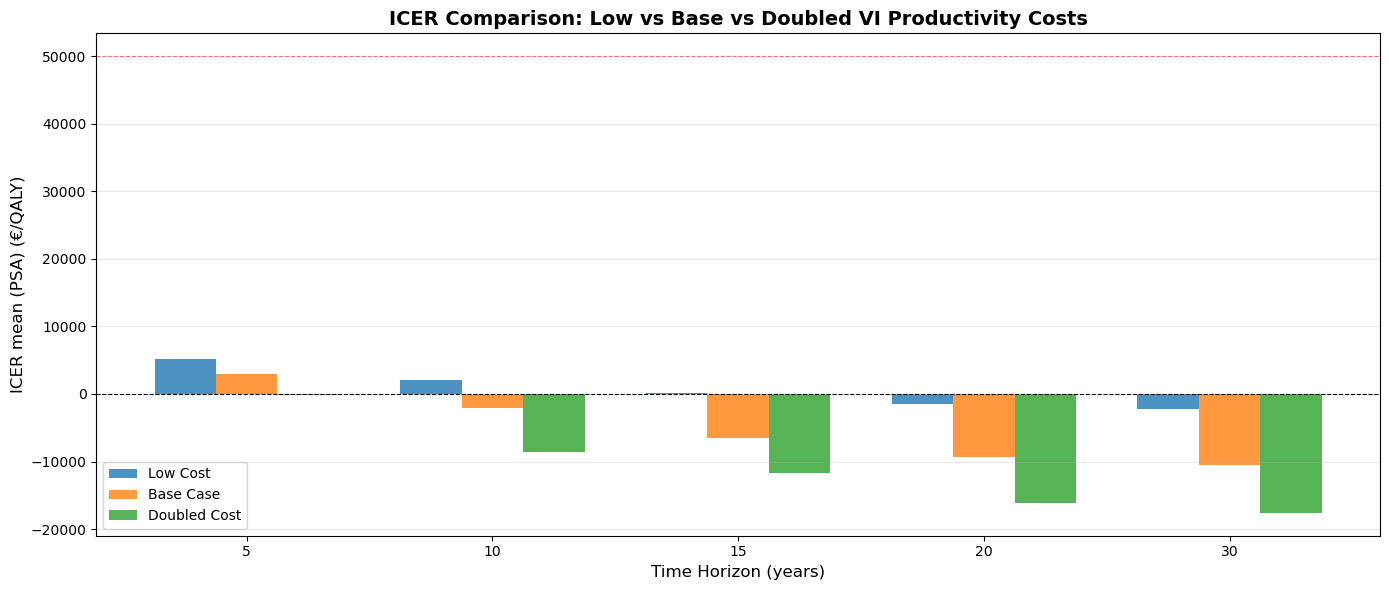

✓ ICER comparison plot saved to ../data/icer_comparison_productivity.png


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

time_horizons = [5, 10, 15, 20, 30]
icers_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_doubled = [results_doubled['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]

x = np.arange(len(time_horizons))
width = 0.25

bars1 = ax.bar(x - width, icers_low, width, label='Low Cost', alpha=0.8)
bars2 = ax.bar(x, icers_base, width, label='Base Case', alpha=0.8)
bars3 = ax.bar(x + width, icers_doubled, width, label='Doubled Cost', alpha=0.8)

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('ICER mean (PSA) (€/QALY)', fontsize=12)
ax.set_title('ICER Comparison: Low vs Base vs Doubled VI Productivity Costs', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(time_horizons)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axhline(y=50000, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='€50k threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/icer_comparison_productivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ICER comparison plot saved to ../data/icer_comparison_productivity.png")

### Probability of Cost-Effectiveness Comparison

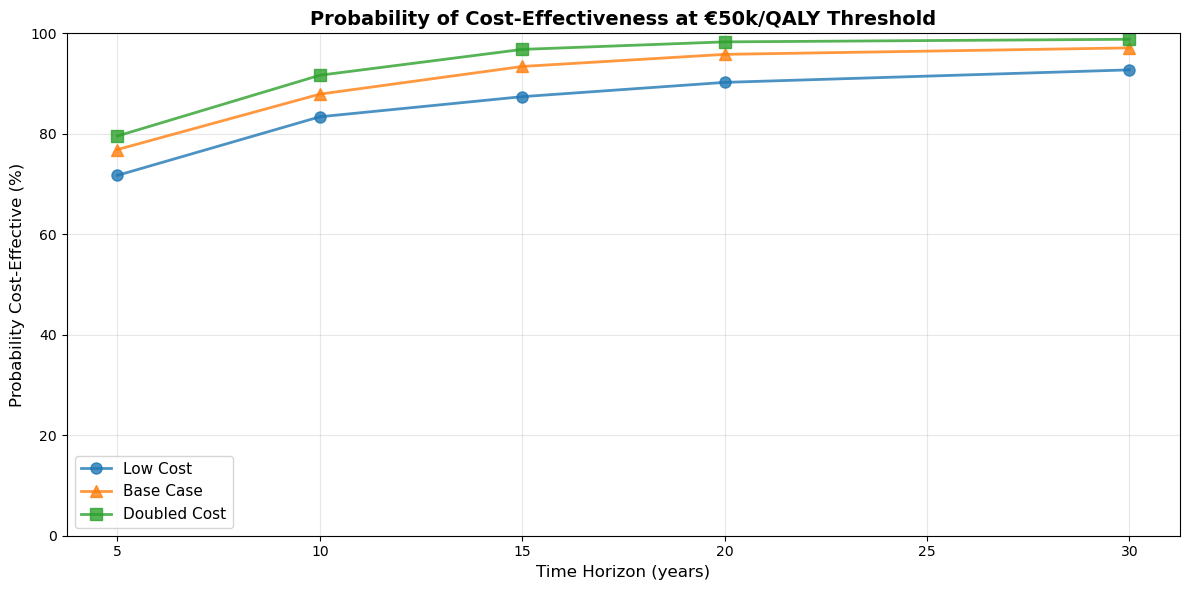

✓ Probability CE comparison plot saved to ../data/prob_ce_comparison_productivity.png


In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

prob_ce_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_doubled = [results_doubled['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]

ax.plot(time_horizons, prob_ce_low, marker='o', linewidth=2, markersize=8, label='Low Cost', alpha=0.8)
ax.plot(time_horizons, prob_ce_base, marker='^', linewidth=2, markersize=8, label='Base Case', alpha=0.8)
ax.plot(time_horizons, prob_ce_doubled, marker='s', linewidth=2, markersize=8, label='Doubled Cost', alpha=0.8)

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Probability of Cost-Effectiveness at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/prob_ce_comparison_productivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Probability CE comparison plot saved to ../data/prob_ce_comparison_productivity.png")

## Summary and Conclusions

In [22]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📊 Files saved:")
print("  - ../data/productivity_low_summary.csv")
print("  - ../data/productivity_base_summary.csv")
print("  - ../data/productivity_doubled_summary.csv")
print("  - ../data/productivity_comparison.csv")
print("  - ../data/icer_comparison.png")
print("  - ../data/prob_ce_comparison.png")

print("\n📈 Key Findings (10-year horizon):")
print(f"  Low Cost Scenario: ICER = €{res_low['icer_mean']:,.0f}/QALY")
print(f"  Base Case Scenario: ICER = €{res_base['icer_mean']:,.0f}/QALY")
print(f"  Doubled Cost Scenario: ICER = €{res_doubled['icer_mean']:,.0f}/QALY")
print(f"\n  Impact of doubling VI productivity costs (Base to Doubled):")
print(f"    ΔICER = €{res_doubled['icer_mean'] - res_base['icer_mean']:,.0f}/QALY")

print("\n✓ All three scenarios have been successfully analyzed and compared.")


ANALYSIS COMPLETE

📊 Files saved:
  - ../data/productivity_low_summary.csv
  - ../data/productivity_base_summary.csv
  - ../data/productivity_doubled_summary.csv
  - ../data/productivity_comparison.csv
  - ../data/icer_comparison.png
  - ../data/prob_ce_comparison.png

📈 Key Findings (10-year horizon):
  Low Cost Scenario: ICER = €-2,162/QALY
  Base Case Scenario: ICER = €-10,457/QALY
  Doubled Cost Scenario: ICER = €-17,602/QALY

  Impact of doubling VI productivity costs (Base to Doubled):
    ΔICER = €-7,145/QALY

✓ All three scenarios have been successfully analyzed and compared.
